In [1]:
import pandas as pd

from mlforecast import MLForecast
from statsforecast import StatsForecast
from sklearn.linear_model import LinearRegression
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, LSTM
from neuralforecast.losses.pytorch import MQLoss
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive
)

def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]# 'f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

In [144]:
# lstm search spacce:

horizon=6

config_lstm = dict(
    input_size=tune.choice([horizon*1, horizon*2]),              # Length of input window
    encoder_hidden_size=tune.randint(100, 300),            # Hidden size of LSTM cells
    encoder_n_layers=tune.randint(2,5),                   # Number of layers in LSTM
    encoder_dropout=tune.loguniform(0.01, 0.7),
    decoder_hidden_size=tune.randint(100, 300),  # size of hidden layer for the MLP decoder.
    decoder_layers=tune.randint(2, 5),   # number of layers for the MLP decoder
    learning_rate=tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    scaler_type=tune.choice(['robust', 'standard']),                   # Scaler type
    max_steps=tune.randint(500, 1500),                    # Max number of training iterations
    batch_size=tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    num_lr_decays=tune.loguniform(0.01, .2)
    # random_seed= tune.randint(1, 20),                       # Random seed
    #hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    #futr_exog_list =['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    #stat_exog_list = ['total_hcp_cnt']
)

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  #futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                  #hist_exog_list = ['total_calls'], # <- Historical exogenous variables
                  #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                  loss = MQLoss(),
                  num_samples=45, # number of configurations explored --> ideally above 25,
                  search_alg=HyperOptSearch())
         ]

In [145]:
df_nixtla2 = df_nixtla[df_nixtla.ds<='2022-05-01'].copy()

nf = NeuralForecast(
     models=model,
     freq='MS')

val_size  = 18 # 3 x 6 months
test_size = 6 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla2, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 47.92it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.184] 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 50.63it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 49.37it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 48.56it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.184, valid_loss=6.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 44.39it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 43.09it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 48.93it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.175, valid_loss=6.790]
Validation: |          | 0/? [00:00

2023-10-30 14:23:18,730	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 59:  25%|██▌       | 3/12 [00:00<00:00, 38.51it/s, v_num=0, train_loss_step=0.166, train_loss_epoch=0.160, valid_loss=13.10]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 78.24it/s, v_num=0, train_loss_step=0.291, train_loss_epoch=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 79.37it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 87.11it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 78.13it/s, v_num=0, train_loss_step=0.276, train_loss_epoch=0.359, valid_loss=7.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 95.63it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 94.16it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 94.62it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 79.92it/s, v_num=0, train_loss_step=0.431, train_loss_epoch=0.326, valid_loss=7.090]
(_train_tune pid=3593) 
Validation: |          | 0/

2023-10-30 14:23:37,787	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 50:  62%|██████▎   | 15/24 [00:00<00:00, 75.05it/s, v_num=0, train_loss_step=0.336, train_loss_epoch=0.350, valid_loss=7.090]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 95.44it/s, v_num=0, train_loss_step=0.291, train_loss_epoch=0.348] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 91.75it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 97.89it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 107.58it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 107.59it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 94.36it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.338, valid_loss=7.030] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 118.98it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 113.80it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 96.36it/s, v_num=0, train_loss_ste

2023-10-30 14:23:53,835	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=3593) 
Epoch 50:  50%|█████     | 12/24 [00:00<00:00, 93.26it/s, v_num=0, train_loss_step=0.345, train_loss_epoch=0.324, valid_loss=7.020]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 75.06it/s, v_num=0, train_loss_step=0.205, train_loss_epoch=0.235] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 92.39it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 93.59it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 94.21it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 75.58it/s, v_num=0, train_loss_step=0.189, train_loss_epoch=0.207, valid_loss=6.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 95.83it/s] 
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 95.26it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 94.33it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 75.10it/s, v_num=0, train_loss_step=0

2023-10-30 14:24:02,420	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  92%|█████████▏| 22/24 [00:00<00:00, 73.28it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.189, valid_loss=7.140]


(_train_tune pid=3593) Seed set to 1


Epoch 21:  96%|█████████▌| 23/24 [00:00<00:00, 72.84it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.184, valid_loss=7.140]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 70.14it/s, v_num=0, train_loss_step=0.321, train_loss_epoch=0.363]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 108.60it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 108.48it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 109.01it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 108.89it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 109.14it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00

2023-10-30 14:24:13,872	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 13:  35%|███▌      | 17/48 [00:00<00:00, 75.74it/s, v_num=0, train_loss_step=0.387, train_loss_epoch=0.340, valid_loss=6.440]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 70.37it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.192]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 85.57it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 73.72it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.192, valid_loss=6.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 89.79it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 11/12 [00:00<00:00, 85.94it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 73.01it/s, v_num=0, train_loss_step=0.214, train_loss_epoch=0.182, valid_loss=7.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 85.51it/s]
(_train_tune pid=3593) 
Epoch 33:  33%

2023-10-30 14:24:22,231	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 45:   8%|▊         | 1/12 [00:00<00:00, 72.38it/s, v_num=0, train_loss_step=0.174, train_loss_epoch=0.192, valid_loss=7.100] 


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 75.91it/s, v_num=0, train_loss_step=0.201, train_loss_epoch=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 79.03it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 79.10it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 65.69it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.198, valid_loss=7.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 72.91it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 11/12 [00:00<00:00, 72.02it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 65.76it/s, v_num=0, train_loss_step=0.219, train_loss_epoch=0.184, valid_loss=6.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 69.45it/s]
(_train_tune pid=3593) 
Valida

2023-10-30 14:24:46,013	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99:  75%|███████▌  | 9/12 [00:00<00:00, 70.96it/s, v_num=0, train_loss_step=0.193, train_loss_epoch=0.186, valid_loss=7.190]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 44.29it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.184]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 33.05it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 32.15it/s]
(_train_tune pid=3593) 
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 30.79it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 43.88it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.184, valid_loss=7.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 31.21it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 48.70it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.193, valid_loss=7.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0

2023-10-30 14:25:04,380	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 122:  83%|████████▎ | 5/6 [00:00<00:00, 44.28it/s, v_num=0, train_loss_step=0.188, train_loss_epoch=0.179, valid_loss=9.220]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 59.25it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.189] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 65.26it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 66.65it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 57.64it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.186, valid_loss=6.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 65.33it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 65.32it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 57.80it/s, v_num=0, train_loss_step=0.202, train_loss_epoch=0.173, valid_loss=7.450]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune p

2023-10-30 14:25:26,352	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 93:  67%|██████▋   | 8/12 [00:00<00:00, 56.44it/s, v_num=0, train_loss_step=0.148, train_loss_epoch=0.175, valid_loss=9.120]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 50.90it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.181]
(_train_tune pid=3593) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 36.97it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 36.43it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 50.16it/s, v_num=0, train_loss_step=0.165, train_loss_epoch=0.178, valid_loss=7.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 37.34it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 50.83it/s, v_num=0, train_loss_step=0.210, train_loss_epoch=0.185, valid_loss=8.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 39.71it/s]

2023-10-30 14:25:41,754	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 116:  67%|██████▋   | 4/6 [00:00<00:00, 49.95it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.160, valid_loss=8.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 37.03it/s]
(_train_tune pid=3593) 
Epoch 116:  67%|██████▋   | 4/6 [00:00<00:00, 15.41it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.160, valid_loss=9.390]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 107.47it/s, v_num=0, train_loss_step=0.300, train_loss_epoch=0.356]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 126.17it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 109.63it/s, v_num=0, train_loss_step=0.278, train_loss_epoch=0.345, valid_loss=7.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 127.12it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 125.91it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 125.84it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 104.55it/s, v_num=0, train_loss_step=0.364, train_loss_epoch=0.317, valid_loss=6.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 130.02it/s]
(_train_tune pid=3593

2023-10-30 14:25:56,023	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 51:  75%|███████▌  | 18/24 [00:00<00:00, 110.49it/s, v_num=0, train_loss_step=0.729, train_loss_epoch=0.335, valid_loss=6.370]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 79.72it/s, v_num=0, train_loss_step=0.161, train_loss_epoch=0.178]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 110.84it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 108.98it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 110.79it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 110.93it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 110.95it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 80.71it/s, v_num=0, train_loss_step=0.161, train_loss_epoch=0.170, valid_loss=9.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 110.38it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 107.53it/s]
(_train_

2023-10-30 14:26:06,860	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 13:  33%|███▎      | 16/48 [00:00<00:00, 81.14it/s, v_num=0, train_loss_step=0.135, train_loss_epoch=0.154, valid_loss=10.30]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 80.14it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.184]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 123.14it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 123.74it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 125.10it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 81.62it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.173, valid_loss=8.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 124.66it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 125.25it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 125.03it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 124.93it/s]
(_tra

2023-10-30 14:26:31,634	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 30:  81%|████████▏ | 39/48 [00:00<00:00, 74.65it/s, v_num=0, train_loss_step=0.153, train_loss_epoch=0.147, valid_loss=11.00]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 94.32it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.189] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 109.30it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 55.83it/s] 
(_train_tune pid=3593) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 72.56it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 73.56it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 62.84it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:02, 19.04it/s, v_num=0, train_loss_step=0.163, train_loss_epoch=0.187, valid_loss=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 121.78it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 114.78it/s]
(_train_

2023-10-30 14:26:52,961	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 22:   6%|▋         | 3/48 [00:00<00:00, 88.38it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.164, valid_loss=9.240] 


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 65.18it/s, v_num=0, train_loss_step=0.321, train_loss_epoch=0.341] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 93.52it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 92.85it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 92.28it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 92.30it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 92.84it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 92.81it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 93.05it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 93.11it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 66.37it/s, v_num=0, tr

2023-10-30 14:27:13,240	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  17%|█▋        | 8/48 [00:00<00:00, 70.96it/s, v_num=0, train_loss_step=0.317, train_loss_epoch=0.311, valid_loss=8.710]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 35.05it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.183]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 36.54it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 36.02it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 35.82it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 35.90it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 34.31it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.176, valid_loss=6.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 29.13it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 28.99it/s]
(_train_tune pid=3593) 
V

2023-10-30 14:27:40,749	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 67:  92%|█████████▏| 11/12 [00:00<00:00, 31.52it/s, v_num=0, train_loss_step=0.146, train_loss_epoch=0.147, valid_loss=12.20]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 40.18it/s, v_num=0, train_loss_step=0.187, train_loss_epoch=0.185]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 74.26it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 72.73it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 72.89it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 41.44it/s, v_num=0, train_loss_step=0.173, train_loss_epoch=0.186, valid_loss=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 72.66it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 71.94it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 71.06it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 71.20it/s]
(_train_tune p

2023-10-30 14:28:04,472	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 35:  46%|████▌     | 11/24 [00:00<00:00, 40.85it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.158, valid_loss=10.80]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 28.19it/s, v_num=0, train_loss_step=0.323, train_loss_epoch=0.349]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 33.89it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 27.31it/s, v_num=0, train_loss_step=0.299, train_loss_epoch=0.347, valid_loss=6.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 33.89it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 32.98it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 27.68it/s, v_num=0, train_loss_step=0.295, train_loss_epoch=0.338, valid_loss=6.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█

2023-10-30 14:29:01,822	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 215:  50%|█████     | 3/6 [00:00<00:00, 26.73it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.301, valid_loss=8.100]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 29.99it/s, v_num=0, train_loss_step=0.306, train_loss_epoch=0.325]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 20.99it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 20.18it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 19.92it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 29.75it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.364, valid_loss=6.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 18.52it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 19.30it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 19.16it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 31.00it/s, v_num=0, train_loss_step=0.412, train_lo

2023-10-30 14:29:43,430	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 191:  17%|█▋        | 1/6 [00:00<00:00, 27.18it/s, v_num=0, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=7.800]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 35.62it/s, v_num=0, train_loss_step=0.173, train_loss_epoch=0.188]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 27.92it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 27.23it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 40.04it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.184, valid_loss=6.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 30.66it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 39.87it/s, v_num=0, train_loss_step=0.200, train_loss_epoch=0.190, valid_loss=7.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 30.65it/s]
(_train_tune pid=3593) 
Validation DataLoader 0

2023-10-30 14:30:13,038	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 178:  67%|██████▋   | 4/6 [00:00<00:00, 38.91it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.187, valid_loss=7.130]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 93.45it/s, v_num=0, train_loss_step=0.279, train_loss_epoch=0.464]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 129.77it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 129.66it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 129.74it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 130.09it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 98.33it/s, v_num=0, train_loss_step=0.288, train_loss_epoch=0.366, valid_loss=7.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 135.14it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 134.34it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 134.33it/s]
(_tr

2023-10-30 14:30:32,830	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 28:  96%|█████████▌| 46/48 [00:00<00:00, 80.03it/s, v_num=0, train_loss_step=0.337, train_loss_epoch=0.338, valid_loss=6.860]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 77.02it/s, v_num=0, train_loss_step=0.335, train_loss_epoch=0.340] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 111.06it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 109.24it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 28.05it/s]
(_train_tune pid=3593) 
Validation DataLoader 0: 100%|██████████| 24/24 [00:01<00:00, 20.82it/s]
                                                                        
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 75.60it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.343, valid_loss=6.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 104.37it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 104.41it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 

2023-10-30 14:30:52,819	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 38:  21%|██        | 5/24 [00:00<00:00, 74.14it/s, v_num=0, train_loss_step=0.252, train_loss_epoch=0.298, valid_loss=8.490] 


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 84.42it/s, v_num=0, train_loss_step=0.355, train_loss_epoch=0.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 118.84it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 117.62it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 87.85it/s, v_num=0, train_loss_step=0.316, train_loss_epoch=0.362, valid_loss=6.970] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 117.45it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 117.31it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 88.92it/s, v_num=0, train_loss_step=0.332, train_loss_epoch=0.342, valid_loss=6.830]
Validation: |          | 0/? [00:00<?, ?it/s]
Validati

2023-10-30 14:31:11,243	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 56:  33%|███▎      | 8/24 [00:00<00:00, 85.34it/s, v_num=0, train_loss_step=0.293, train_loss_epoch=0.307, valid_loss=6.770]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 62.35it/s, v_num=0, train_loss_step=0.412, train_loss_epoch=0.333] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 80.46it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 80.62it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 80.55it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 80.62it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 80.28it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 80.20it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 80.20it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 61.46it/s, v_num=0, train_loss_step=0.306, train_loss_epoch=0.348, valid_loss=6.970]
Validation: |          | 0/? [00:

2023-10-30 14:31:43,383	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 29:  40%|███▉      | 19/48 [00:00<00:01, 19.42it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.269, valid_loss=10.30]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 116.22it/s, v_num=0, train_loss_step=0.255, train_loss_epoch=0.350] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 127.92it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 127.17it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 123.82it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 123.42it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 122.79it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 119.05it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 115.22it/s, v_num=0, train_loss_step=0.272, train_loss_epoch=0.331, valid_loss=7.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 119.54it/s]
(_tr

2023-10-30 14:31:55,127	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 63.93it/s, v_num=0, train_loss_step=0.339, train_loss_epoch=0.325] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 92.29it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 88.98it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 90.35it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 62.75it/s, v_num=0, train_loss_step=0.290, train_loss_epoch=0.320, valid_loss=7.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 89.47it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 88.16it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 88.11it/s]
(_train_tune pid=3593

2023-10-30 14:32:19,026	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 53:  29%|██▉       | 7/24 [00:00<00:00, 63.13it/s, v_num=0, train_loss_step=0.261, train_loss_epoch=0.266, valid_loss=10.30]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 76.55it/s, v_num=0, train_loss_step=0.371, train_loss_epoch=0.369]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 92.96it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 92.48it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 92.35it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 91.97it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 91.91it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 92.06it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 92.02it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 91.84it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 91.80

2023-10-30 14:32:31,917	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=3593) 
Epoch 12:  73%|███████▎  | 35/48 [00:01<00:00, 30.24it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.369, valid_loss=7.470]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 73.01it/s, v_num=0, train_loss_step=0.365, train_loss_epoch=0.386] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 104.94it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 104.69it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 60.92it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 70.57it/s, v_num=0, train_loss_step=0.320, train_loss_epoch=0.367, valid_loss=7.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 102.77it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 18.36it/s] 
(_train_tune pid=3593) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 34.97it/s]
(_train_tune pid=

2023-10-30 14:32:50,577	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=3593) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 60.83it/s] 
(_train_tune pid=3593) 
Epoch 33:  58%|█████▊    | 14/24 [00:00<00:00, 20.78it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.344, valid_loss=6.960]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 53.61it/s, v_num=0, train_loss_step=0.370, train_loss_epoch=0.335]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 59.28it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 58.85it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 58.71it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 58.85it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 63.33it/s, v_num=0, train_loss_step=0.308, train_loss_epoch=0.342, valid_loss=6.870]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 91.29it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 90.90it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 91.05it/s]
(_train_tune p

2023-10-30 14:33:19,402	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 61:  21%|██        | 5/24 [00:00<00:00, 61.67it/s, v_num=0, train_loss_step=0.218, train_loss_epoch=0.259, valid_loss=11.20]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 72.69it/s, v_num=0, train_loss_step=0.272, train_loss_epoch=0.353] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 80.52it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 82.75it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 83.26it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 83.93it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 83.60it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 83.72it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 73.25it/s, v_num=0, train_loss_step=0.288, train_loss_epoch=0.351, valid_loss=6.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 80.04it/s]
(_train_tune

2023-10-30 14:33:35,698	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=3593) 
Epoch 19:   6%|▋         | 3/48 [00:00<00:00, 75.04it/s, v_num=0, train_loss_step=0.310, train_loss_epoch=0.329, valid_loss=7.580] 


(_train_tune pid=3593) Seed set to 1


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 42.14it/s]
                                                                           
Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 63.41it/s, v_num=0, train_loss_step=0.368, train_loss_epoch=0.333] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 89.03it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 87.97it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 87.22it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 87.15it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 64.08it/s, v_num=0, train_loss_step=0.298, train_loss_epoch=0.342, valid_loss=7.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍       

2023-10-30 14:34:00,248	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 53:  79%|███████▉  | 19/24 [00:00<00:00, 60.16it/s, v_num=0, train_loss_step=0.283, train_loss_epoch=0.263, valid_loss=10.50]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 108.29it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.341] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 116.99it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 115.96it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 114.10it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 112.88it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 114.60it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 103.53it/s, v_num=0, train_loss_step=0.257, train_loss_epoch=0.323, valid_loss=7.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 119.28it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 119.48it/s]
(_tr

2023-10-30 14:34:15,853	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 71.51it/s, v_num=0, train_loss_step=0.328, train_loss_epoch=0.391] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 86.79it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 84.40it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 84.11it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 73.45it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=0.370, valid_loss=6.560]
(_train_tune pid=3593) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:00, 88.31it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 87.60it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  79%|███████▉  | 19/2

2023-10-30 14:34:39,084	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 66.87it/s, v_num=0, train_loss_step=0.288, train_loss_epoch=0.341]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 49.29it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 48.47it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 69.08it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.356, valid_loss=6.920]
(_train_tune pid=3593) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 48.57it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 48.28it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 63.21it/s, v_num=0, train_loss_step=0.353, train_loss_epoch=0.322, valid_loss=6.650]
Validation: 

2023-10-30 14:35:02,011	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=3593) 
Epoch 100:  75%|███████▌  | 9/12 [00:00<00:00, 70.49it/s, v_num=0, train_loss_step=0.323, train_loss_epoch=0.301, valid_loss=7.280]


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 95.85it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=0.350] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 114.80it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 114.27it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 112.68it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 112.54it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 100.26it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.339, valid_loss=7.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 119.48it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 117.22it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 97.58it/s, v_num=0, train_loss_s

2023-10-30 14:35:14,490	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 41:  67%|██████▋   | 16/24 [00:00<00:00, 101.54it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.332, valid_loss=7.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 118.52it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 115.39it/s]


(_train_tune pid=3593) Seed set to 1


(_train_tune pid=3593) 
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 106.34it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.340] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 127.56it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 122.00it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 122.04it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 122.88it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 111.55it/s, v_num=0, train_loss_step=0.259, train_loss_epoch=0.323, valid_loss=6.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 127.50it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 126.93it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:

2023-10-30 14:35:29,724	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=3593) Seed set to 1


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 54.72it/s]
                                                                           
Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 107.33it/s, v_num=0, train_loss_step=0.297, train_loss_epoch=0.352] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 132.77it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 125.17it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 105.48it/s, v_num=0, train_loss_step=0.274, train_loss_epoch=0.341, valid_loss=6.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 127.02it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 124.77it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 

2023-10-30 14:35:45,184	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 56:  54%|█████▍    | 13/24 [00:00<00:00, 105.14it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.309, valid_loss=8.550]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 88.77it/s, v_num=0, train_loss_step=0.298, train_loss_epoch=0.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 103.96it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 89.23it/s, v_num=0, train_loss_step=0.282, train_loss_epoch=0.367, valid_loss=7.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 117.62it/s]
(_train_tune pid=3593) 
Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 102.25it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 89.81it/s, v_num=0, train_loss_step=0.352, train_loss_epoch=0.326, valid_loss=6.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 105.53it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 103.63it/s]
(_train_tune pid=3593) 
E

2023-10-30 14:36:00,959	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 103:  83%|████████▎ | 10/12 [00:00<00:00, 90.47it/s, v_num=0, train_loss_step=0.243, train_loss_epoch=0.317, valid_loss=7.190]


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 51.61it/s, v_num=0, train_loss_step=0.276, train_loss_epoch=0.307]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 39.59it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 36.51it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 35.69it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 52.10it/s, v_num=0, train_loss_step=0.261, train_loss_epoch=0.338, valid_loss=6.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 34.42it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 34.52it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 52.18it/s, v_num=0, train_loss_step=0.475, train_loss_epoch=0.355, valid_loss=6.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation Data

2023-10-30 14:36:33,698	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 239:  50%|█████     | 3/6 [00:00<00:00, 49.07it/s, v_num=0, train_loss_step=0.263, train_loss_epoch=0.268, valid_loss=7.470]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 104.40it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.343]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 123.56it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 118.90it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 114.27it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:01, 28.59it/s] 
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 42.16it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  79%|███████▉  | 38/48 [00:01<00:00, 29.79it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 93.87it/s, v_num=0, train_loss_step=0.269, train_loss_epoch=0.332, valid_loss=7.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 115.13it/s]
(_train_

2023-10-30 14:36:55,023	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 23:  58%|█████▊    | 28/48 [00:00<00:00, 109.76it/s, v_num=0, train_loss_step=0.353, train_loss_epoch=0.330, valid_loss=6.630]


(_train_tune pid=3593) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 80.38it/s, v_num=0, train_loss_step=0.290, train_loss_epoch=0.341]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 56.47it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 55.51it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 55.29it/s]
(_train_tune pid=3593) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 81.61it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.356, valid_loss=6.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 55.05it/s]
(_train_tune pid=3593) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 80.13it/s, v_num=0, train_loss_step=0.350, train_loss_epoch=0.322, valid_loss=6.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation Dat

2023-10-30 14:37:15,331	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 111:  17%|█▋        | 2/12 [00:00<00:00, 70.24it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.333, valid_loss=7.520] 


(_train_tune pid=3593) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 112.19it/s, v_num=0, train_loss_step=0.298, train_loss_epoch=0.356]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 125.25it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 122.00it/s]
(_train_tune pid=3593) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 113.81it/s, v_num=0, train_loss_step=0.278, train_loss_epoch=0.344, valid_loss=6.840] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 130.95it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 120.04it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 119.03it/s]
(_train_tune pid=3593) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 108.91it/s, v_num=0, train_loss_step=0.3

2023-10-30 14:37:29,119	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 51:   0%|          | 0/24 [00:00<?, ?it/s, v_num=0, train_loss_step=0.511, train_loss_epoch=0.339, valid_loss=6.700]          


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 116.12it/s, v_num=0, train_loss_step=0.246, train_loss_epoch=0.342] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 139.28it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 139.65it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 139.28it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 120.00it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.326, valid_loss=7.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 144.16it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 144.02it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 142.90it/s]
(_train_tun

2023-10-30 14:37:40,642	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 20:   4%|▍         | 2/48 [00:00<00:00, 104.96it/s, v_num=0, train_loss_step=0.413, train_loss_epoch=0.361, valid_loss=6.590] 


(_train_tune pid=3593) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 67.10it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.182]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 51.92it/s]
(_train_tune pid=3593) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 66.54it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.181, valid_loss=7.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 53.60it/s]
(_train_tune pid=3593) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 66.15it/s, v_num=0, train_loss_step=0.209, train_loss_epoch=0.184, valid_loss=7.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 50.79it/s]
(_train_tune pid=3593) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 64.87it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.169, valid_loss=8.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%

2023-10-30 14:37:58,020	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 171:  50%|█████     | 3/6 [00:00<00:00, 65.52it/s, v_num=0, train_loss_step=0.152, train_loss_epoch=0.176, valid_loss=10.20]


(_train_tune pid=3593) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 100.92it/s, v_num=0, train_loss_step=0.235, train_loss_epoch=0.341]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 122.64it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 123.04it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 122.16it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 121.72it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 121.19it/s]
(_train_tune pid=3593) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 99.39it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.327, valid_loss=7.970]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 115.49it/s]
(_train_tune pid=3593) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 116.95it/s]
(_tr

2023-10-30 14:38:14,450	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 24:  15%|█▍        | 7/48 [00:00<00:00, 94.46it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.296, valid_loss=6.830] 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [146]:
nf.models[0].results.get_best_result().config

{'input_size': 6,
 'encoder_hidden_size': 185,
 'encoder_n_layers': 2,
 'encoder_dropout': 0.37109653505311996,
 'decoder_hidden_size': 209,
 'decoder_layers': 2,
 'learning_rate': 0.0033241444294620152,
 'scaler_type': 'robust',
 'max_steps': 1166,
 'batch_size': 16,
 'num_lr_decays': 0.123298294768961,
 'h': 6,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [147]:
nf.fit(df=df_nixtla2)

(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 34.31it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 31.79it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 31.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 31.64it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 42.50it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.189, valid_loss=5.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 29.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 29.22it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 30.26it/s]
(_train_tune pid=13174) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 37.38it/s, v_num=0, train_loss_step=

2023-10-30 14:39:03,470	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 78.47it/s, v_num=0, train_loss_step=0.400, train_loss_epoch=0.383] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 89.64it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 86.87it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 85.74it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 75.61it/s, v_num=0, train_loss_step=0.324, train_loss_epoch=0.440, valid_loss=6.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 92.26it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 90.89it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 88.51it/s]
(_train_tune pid

2023-10-30 14:39:23,080	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 87.71it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 100.73it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 100.83it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 100.56it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 90.14it/s, v_num=0, train_loss_step=0.263, train_loss_epoch=0.340, valid_loss=3.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 96.87it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 99.35it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 88.04it/s, v_num=0, train_loss_step=0.304, train_loss_epoch=0.348, valid_loss=3.630]
Validation: |          | 0/? [00:00<?, ?it/

2023-10-30 14:39:40,038	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Epoch 50:  50%|█████     | 12/24 [00:00<00:00, 80.23it/s, v_num=0, train_loss_step=0.276, train_loss_epoch=0.302, valid_loss=3.480]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 70.00it/s, v_num=0, train_loss_step=0.235, train_loss_epoch=0.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 85.63it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 84.78it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 85.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 85.45it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 74.96it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.200, valid_loss=5.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 87.89it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 87.57it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 87.49it/s]
(_train_

2023-10-30 14:39:49,228	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  96%|█████████▌| 23/24 [00:00<00:00, 68.27it/s, v_num=0, train_loss_step=0.157, train_loss_epoch=0.188, valid_loss=5.530]


(_train_tune pid=13174) Seed set to 1


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 23.32it/s]
Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 72.39it/s, v_num=0, train_loss_step=0.330, train_loss_epoch=0.457]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 93.13it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 94.64it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 94.48it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 94.94it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 94.59it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 71.78it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.421, valid_loss=5.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 

2023-10-30 14:40:01,554	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 13:  44%|████▍     | 21/48 [00:00<00:00, 70.51it/s, v_num=0, train_loss_step=0.417, train_loss_epoch=0.332, valid_loss=4.050]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 69.75it/s, v_num=0, train_loss_step=0.188, train_loss_epoch=0.204]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 78.05it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 77.09it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 70.37it/s, v_num=0, train_loss_step=0.189, train_loss_epoch=0.178, valid_loss=5.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 80.52it/s]
(_train_tune pid=13174) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 69.77it/s, v_num=0, train_loss_step=0.201, train_loss_epoch=0.185, valid_loss=5.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 79.15it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 4/12 [00:00<00:00, 70.12it/s, v_num=0, train_loss_step=0.186, train_loss

2023-10-30 14:40:10,634	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 45:  25%|██▌       | 3/12 [00:00<00:00, 67.36it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.186, valid_loss=5.460]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 74.21it/s, v_num=0, train_loss_step=0.214, train_loss_epoch=0.275] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 78.69it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 73.89it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 73.04it/s, v_num=0, train_loss_step=0.196, train_loss_epoch=0.184, valid_loss=5.680]
(_train_tune pid=13174) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 64.59it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 65.50it/s]
(_train_tune pid=13174) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 74.91it/s, v_num=0, train_loss_step=0.206, train_loss_epoch=0.187, valid_loss=5.280]
Valid

2023-10-30 14:40:29,661	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99:  75%|███████▌  | 9/12 [00:00<00:00, 68.35it/s, v_num=0, train_loss_step=0.155, train_loss_epoch=0.180, valid_loss=4.790]


(_train_tune pid=13174) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 37.44it/s, v_num=0, train_loss_step=0.179, train_loss_epoch=0.196]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 27.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 26.13it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 36.96it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.182, valid_loss=5.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00,  6.77it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00,  9.40it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 34.93it/s, v_num=0, train_loss_step=0.179, train_loss_epoch=0.181, valid_loss=5.750]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoa

2023-10-30 14:40:56,945	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 122:  17%|█▋        | 1/6 [00:00<00:00, 39.80it/s, v_num=0, train_loss_step=0.156, train_loss_epoch=0.165, valid_loss=3.620]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 56.54it/s, v_num=0, train_loss_step=0.186, train_loss_epoch=0.195]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 35.43it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 45.10it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 11/12 [00:00<00:00, 44.32it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 56.98it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.180, valid_loss=5.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 48.57it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 43.31it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 42.58it/s]
(_train_tune pid=

2023-10-30 14:41:20,511	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 94:   8%|▊         | 1/12 [00:00<00:00, 49.65it/s, v_num=0, train_loss_step=0.156, train_loss_epoch=0.156, valid_loss=4.010] 


(_train_tune pid=13174) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 49.24it/s, v_num=0, train_loss_step=0.165, train_loss_epoch=0.174]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 32.93it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 31.48it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 51.18it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.165, valid_loss=4.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 33.27it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 30.83it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 49.93it/s, v_num=0, train_loss_step=0.174, train_loss_epoch=0.172, valid_loss=3.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoa

2023-10-30 14:41:36,385	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Epoch 116: 100%|██████████| 6/6 [00:00<00:00, 17.83it/s, v_num=0, train_loss_step=0.179, train_loss_epoch=0.167, valid_loss=3.770]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 106.05it/s, v_num=0, train_loss_step=0.251, train_loss_epoch=0.366] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 120.61it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 118.22it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 116.34it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 108.49it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.340, valid_loss=3.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 115.60it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 114.83it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 113.64it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 108.51it/s, v_num=0, train

2023-10-30 14:41:50,906	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 51:  75%|███████▌  | 18/24 [00:00<00:00, 108.00it/s, v_num=0, train_loss_step=0.299, train_loss_epoch=0.328, valid_loss=3.570]


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 73.43it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.181]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 96.27it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 97.39it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 96.85it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 97.26it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 97.83it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 78.11it/s, v_num=0, train_loss_step=0.175, train_loss_epoch=0.169, valid_loss=3.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 99.21it/s] 
(_train_tune pid=13174) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 98.93it/s]
(_trai

2023-10-30 14:42:02,226	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 13:  42%|████▏     | 20/48 [00:00<00:00, 75.68it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.163, valid_loss=4.260]


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 83.22it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.188]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 115.40it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 115.43it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 115.50it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 113.79it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 114.06it/s]
(_train_tune pid=13174) 
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 114.51it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 79.43it/s, v_num=0, train_loss_step=0.160, train_loss_epoch=0.173, valid_loss=4.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 111.26it/s]

2023-10-30 14:42:27,554	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 30:  75%|███████▌  | 36/48 [00:00<00:00, 73.06it/s, v_num=0, train_loss_step=0.151, train_loss_epoch=0.159, valid_loss=3.850]


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 85.71it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.184] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 95.21it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 99.02it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 102.55it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 102.66it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 103.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 105.22it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 105.76it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 83.18it/s, v_num=0, train_loss_step=0.158, train_loss_epoch=0.185, valid_loss=5.460]
Validation: |         

2023-10-30 14:42:50,166	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 22:   6%|▋         | 3/48 [00:00<00:01, 23.71it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.172, valid_loss=4.240]


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 60.73it/s, v_num=0, train_loss_step=0.311, train_loss_epoch=0.433] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 79.80it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 80.70it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 80.45it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 79.91it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 79.22it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 79.21it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 58.40it/s, v_num=0, train_loss_step=0.248, train_loss_epoch=0.422, valid_loss=5.960]
Validation: |          | 0/? [00:00

2023-10-30 14:43:12,022	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 21:  19%|█▉        | 9/48 [00:00<00:00, 68.55it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.382, valid_loss=5.280]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 34.15it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.188]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 26.77it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 25.75it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 25.82it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 25.77it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 34.06it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.188, valid_loss=5.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 26.44it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 26.06it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 25.89it/s]
(_train_tu

2023-10-30 14:43:40,100	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 67:  92%|█████████▏| 11/12 [00:00<00:00, 33.62it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0.166, valid_loss=4.120]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 44.22it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.186]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 67.12it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 67.12it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 67.09it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 66.88it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 44.57it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.187, valid_loss=5.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 68.88it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:00, 66.

2023-10-30 14:44:03,045	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 35:  54%|█████▍    | 13/24 [00:00<00:00, 41.53it/s, v_num=0, train_loss_step=0.180, train_loss_epoch=0.183, valid_loss=5.650]


(_train_tune pid=13174) Seed set to 1


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 25.91it/s]
                                                                           
Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 27.44it/s, v_num=0, train_loss_step=0.369, train_loss_epoch=0.431]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 31.31it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 29.03it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 26.89it/s, v_num=0, train_loss_step=0.318, train_loss_epoch=0.432, valid_loss=5.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 30.29it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 29.22it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 26.88it/s, v_num=0, train_loss_step=0.940, train_loss_epoch=0.427, valid_loss=5.540]


2023-10-30 14:45:01,968	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 215:  67%|██████▋   | 4/6 [00:00<00:00, 23.62it/s, v_num=0, train_loss_step=0.596, train_loss_epoch=0.383, valid_loss=3.520]


(_train_tune pid=13174) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 29.51it/s, v_num=0, train_loss_step=0.346, train_loss_epoch=0.433]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 17.17it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 29.36it/s, v_num=0, train_loss_step=0.712, train_loss_epoch=0.410, valid_loss=5.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 18.05it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 17.31it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 17.25it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 17.09it/s]
(_train_tune pid=13174) 
Ep

2023-10-30 14:45:44,806	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 191:  17%|█▋        | 1/6 [00:00<00:00, 27.89it/s, v_num=0, train_loss_step=0.295, train_loss_epoch=0.295, valid_loss=3.620]


(_train_tune pid=13174) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 40.98it/s, v_num=0, train_loss_step=0.185, train_loss_epoch=0.208]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 27.52it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 27.17it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 27.19it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 39.72it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.180, valid_loss=5.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 27.68it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 27.34it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 40.86it/s, v_num=0, train_loss_step=0.207, train_loss

2023-10-30 14:46:14,273	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 178:  67%|██████▋   | 4/6 [00:00<00:00, 39.48it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.187, valid_loss=5.550]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 102.80it/s, v_num=0, train_loss_step=0.232, train_loss_epoch=0.352] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 114.52it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 112.56it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 102.84it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.339, valid_loss=3.580] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 121.74it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 116.03it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 112.02it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 101.45it/s, v_num=0, train_loss_step=0.303, train_loss_epoch=0.348, valid_loss=3.600]
(_train_tune pid=13174) 
Validation: 

2023-10-30 14:46:31,451	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 57:   8%|▊         | 2/24 [00:00<00:00, 98.15it/s, v_num=0, train_loss_step=0.256, train_loss_epoch=0.352, valid_loss=3.190] 


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 70.97it/s, v_num=0, train_loss_step=0.220, train_loss_epoch=0.346]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 84.37it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 87.59it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 63.91it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 86.72it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.340, valid_loss=3.480] 
(_train_tune pid=13174) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:01, 13.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 24.80it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 90.53it/s, v_num

2023-10-30 14:46:54,441	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 57:  33%|███▎      | 8/24 [00:00<00:00, 99.90it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.536, valid_loss=3.270] 


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 100.69it/s, v_num=0, train_loss_step=0.232, train_loss_epoch=0.355] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 111.69it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 112.78it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 112.04it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 101.45it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.340, valid_loss=3.660]
(_train_tune pid=13174) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 116.97it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 117.02it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/

2023-10-30 14:47:12,597	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 61:  83%|████████▎ | 20/24 [00:00<00:00, 100.58it/s, v_num=0, train_loss_step=0.286, train_loss_epoch=0.348, valid_loss=3.450]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 100.63it/s, v_num=0, train_loss_step=0.233, train_loss_epoch=0.351] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 111.97it/s]
(_train_tune pid=13174) 
Validation DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 110.43it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 100.81it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.341, valid_loss=3.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 112.80it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 111.56it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 110.67it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 110.37it/s]
(_train

2023-10-30 14:47:29,570	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 56:  21%|██        | 5/24 [00:00<00:00, 98.78it/s, v_num=0, train_loss_step=0.343, train_loss_epoch=0.359, valid_loss=3.240] 


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 99.21it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.372]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 118.18it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 112.04it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 100.73it/s, v_num=0, train_loss_step=0.273, train_loss_epoch=0.340, valid_loss=4.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:00, 115.38it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 114.83it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 113.98it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 99.76it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.347, valid_loss=3.670]
Validation: |          | 0/? [00:00<?,

2023-10-30 14:47:46,666	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 57:  58%|█████▊    | 14/24 [00:00<00:00, 99.54it/s, v_num=0, train_loss_step=0.225, train_loss_epoch=0.354, valid_loss=3.210]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 108.53it/s, v_num=0, train_loss_step=0.226, train_loss_epoch=0.357] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 120.10it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 110.94it/s, v_num=0, train_loss_step=0.263, train_loss_epoch=0.340, valid_loss=3.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 124.00it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 120.82it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 120.32it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 111.92it/s, v_num=0, train_loss_step=0.304, train_loss_epoch=0.347, valid_loss=3.630]
Validation: |          | 0/? [00:00<?, ?it/s]


2023-10-30 14:48:02,446	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 94.85it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.382]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 112.78it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 111.15it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 111.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 111.13it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 98.18it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.340, valid_loss=4.650] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 109.94it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 109.60it/s]
(_train_t

2023-10-30 14:48:14,490	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 39:  12%|█▎        | 3/24 [00:00<00:00, 92.47it/s, v_num=0, train_loss_step=0.420, train_loss_epoch=0.381, valid_loss=3.330] 


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 89.28it/s, v_num=0, train_loss_step=0.257, train_loss_epoch=0.413] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 103.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 101.28it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 88.54it/s, v_num=0, train_loss_step=0.295, train_loss_epoch=0.362, valid_loss=5.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 106.44it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 105.35it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 87.19it/s, v_num=0, train_loss_step=0.303, train_loss_epoch=0.355, valid_loss=5.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 102.09it/s]
(_train_tune pid=131

2023-10-30 14:48:39,573	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 59:  96%|█████████▌| 23/24 [00:01<00:00, 21.93it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.375, valid_loss=3.560]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 86.84it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.386] 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 96.73it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 96.51it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 96.43it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 87.37it/s, v_num=0, train_loss_step=0.271, train_loss_epoch=0.340, valid_loss=4.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 97.91it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 97.59it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 9

2023-10-30 14:48:58,235	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 105.18it/s, v_num=0, train_loss_step=0.253, train_loss_epoch=0.412] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 119.17it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 115.95it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 115.61it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 105.90it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.358, valid_loss=5.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 118.56it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 116.80it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 116.69it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 101.18it/s, v_num=0, tra

2023-10-30 14:49:15,392	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Epoch 58:  83%|████████▎ | 20/24 [00:00<00:00, 48.87it/s, v_num=0, train_loss_step=0.241, train_loss_epoch=0.406, valid_loss=3.450]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 87.98it/s, v_num=0, train_loss_step=0.233, train_loss_epoch=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 102.74it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 109.28it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 101.69it/s, v_num=0, train_loss_step=0.268, train_loss_epoch=0.340, valid_loss=3.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 115.72it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 115.02it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 111.65it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 111.36it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 99.77it/s, v_num=0, train

2023-10-30 14:49:27,218	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 39:  12%|█▎        | 3/24 [00:00<00:00, 96.55it/s, v_num=0, train_loss_step=0.414, train_loss_epoch=0.365, valid_loss=3.430]  


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 108.05it/s, v_num=0, train_loss_step=0.243, train_loss_epoch=0.374]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 116.50it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 114.67it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 107.54it/s, v_num=0, train_loss_step=0.268, train_loss_epoch=0.339, valid_loss=4.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 114.87it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 106.00it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.346, valid_loss=3.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 118.44it/s]
(_train_tune pid=13174) 
V

2023-10-30 14:49:42,517	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 54:  17%|█▋        | 4/24 [00:00<00:00, 106.00it/s, v_num=0, train_loss_step=0.327, train_loss_epoch=0.336, valid_loss=3.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 118.91it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 118.71it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 117.43it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 117.26it/s]


(_train_tune pid=13174) Seed set to 1


(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 94.30it/s, v_num=0, train_loss_step=0.226, train_loss_epoch=0.355]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 109.80it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 108.17it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 108.27it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 93.86it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.342, valid_loss=3.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 111.56it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 109.17it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 108.72it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 93.

2023-10-30 14:50:02,338	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 62:  29%|██▉       | 7/24 [00:00<00:00, 87.98it/s, v_num=0, train_loss_step=0.336, train_loss_epoch=0.326, valid_loss=3.560]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 82.88it/s, v_num=0, train_loss_step=0.317, train_loss_epoch=0.466]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 53.67it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 52.41it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 83.69it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.376, valid_loss=5.550]
(_train_tune pid=13174) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 52.42it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 11/12 [00:00<00:00, 51.68it/s]
(_train_tune pid=13174) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 84.86it/s, v_num=0, train_loss_step=0.562, train_loss_epoch=0.314, valid_loss=4.500]
Validation: |          | 0/? [

2023-10-30 14:50:19,053	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 95:   0%|          | 0/12 [00:00<?, ?it/s, v_num=0, train_loss_step=0.397, train_loss_epoch=0.426, valid_loss=3.570]         


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 97.57it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.368]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 106.62it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:00, 106.44it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 107.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 106.82it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 95.55it/s, v_num=0, train_loss_step=0.268, train_loss_epoch=0.338, valid_loss=3.990] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 107.29it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 103.58it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 102.72it/s]


2023-10-30 14:50:39,907	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 52:  42%|████▏     | 10/24 [00:00<00:00, 80.85it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=0.303, valid_loss=3.390]


(_train_tune pid=13174) Seed set to 1


Epoch 52:  46%|████▌     | 11/24 [00:00<00:00, 79.84it/s, v_num=0, train_loss_step=0.433, train_loss_epoch=0.316, valid_loss=3.390]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 55.72it/s, v_num=0, train_loss_step=0.338, train_loss_epoch=0.476]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 75.28it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 76.13it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  62%|██████▎   | 15/24 [00:00<00:00, 77.02it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 77.15it/s]
(_train_tune pid=13174) 
Validation DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 77.47it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 53.60it/s, v_num=0, train_loss_step=1.940, train_loss_epoch=0.455, valid_loss=5.600]
Validation: |          | 0/? [00:00<?, ?i

2023-10-30 14:51:10,069	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 59:  79%|███████▉  | 19/24 [00:00<00:00, 62.93it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.449, valid_loss=5.530]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 78.02it/s, v_num=0, train_loss_step=0.278, train_loss_epoch=0.347] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 86.30it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 80.47it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 77.44it/s, v_num=0, train_loss_step=0.275, train_loss_epoch=0.355, valid_loss=5.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 80.07it/s]
(_train_tune pid=13174) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 78.20it/s, v_num=0, train_loss_step=0.349, train_loss_epoch=0.328, valid_loss=3.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 90.17it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 80.93it/s]
(_train_tune pid=13174) 


2023-10-30 14:51:29,781	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 110:  42%|████▏     | 5/12 [00:00<00:00, 75.53it/s, v_num=0, train_loss_step=0.310, train_loss_epoch=0.362, valid_loss=3.350] 


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 94.58it/s, v_num=0, train_loss_step=0.363, train_loss_epoch=0.493]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 91.54it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 91.46it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 93.54it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 93.77it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 94.83it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 95.55it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 95.38it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 95.43it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 92.50it/s, v_

2023-10-30 14:51:47,250	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 24:  48%|████▊     | 23/48 [00:00<00:00, 100.31it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.330, valid_loss=3.940]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 99.48it/s, v_num=0, train_loss_step=0.239, train_loss_epoch=0.347]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 116.01it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 113.92it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 111.67it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 102.43it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.344, valid_loss=3.460] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 120.86it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 114.40it/s]
(_train_tune pid=13174) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 99.50it/s, v_num=0, train_loss_ste

2023-10-30 14:52:00,508	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 45:   8%|▊         | 2/24 [00:00<00:00, 98.90it/s, v_num=0, train_loss_step=0.382, train_loss_epoch=0.314, valid_loss=3.770] 


(_train_tune pid=13174) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 58.86it/s, v_num=0, train_loss_step=0.253, train_loss_epoch=0.409]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 40.68it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 40.57it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 60.67it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.336, valid_loss=5.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 45.51it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 40.92it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 61.30it/s, v_num=0, train_loss_step=0.326, train_loss_epoch=0.353, valid_loss=3.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoa

2023-10-30 14:52:23,240	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Epoch 201:  83%|████████▎ | 5/6 [00:00<00:00, 58.14it/s, v_num=0, train_loss_step=0.295, train_loss_epoch=0.333, valid_loss=3.240]


(_train_tune pid=13174) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 33.50it/s, v_num=0, train_loss_step=0.301, train_loss_epoch=0.432]
(_train_tune pid=13174) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 33.36it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 32.09it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 31.77it/s]
(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 35.95it/s, v_num=0, train_loss_step=0.318, train_loss_epoch=0.408, valid_loss=4.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 38.77it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 33.93it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  67%|██████▋   

2023-10-30 14:52:58,195	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 80:  33%|███▎      | 4/12 [00:00<00:00, 41.13it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.301, valid_loss=3.380]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 111.78it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.347] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 130.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 123.30it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 107.45it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.342, valid_loss=3.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 115.60it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 115.25it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 116.75it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 116.82it/s]
(_train_

2023-10-30 14:53:08,065	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 36:  29%|██▉       | 7/24 [00:00<00:00, 109.56it/s, v_num=0, train_loss_step=0.283, train_loss_epoch=0.327, valid_loss=3.820]


(_train_tune pid=13174) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 75.82it/s, v_num=0, train_loss_step=0.357, train_loss_epoch=0.422]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 85.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 85.08it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 84.10it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 84.58it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  71%|███████   | 34/48 [00:00<00:00, 85.41it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 85.70it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 85.64it/s]
(_train_tune pid=13174) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 81.48it/s, v_num=0, train_loss_step=0.275, train_loss_epoch=0.407, valid_loss=4.360]
Validation: |          | 0/?

2023-10-30 14:53:34,260	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=13174) 
Epoch 29:  38%|███▊      | 18/48 [00:00<00:01, 21.54it/s, v_num=0, train_loss_step=0.281, train_loss_epoch=0.580, valid_loss=3.260]


(_train_tune pid=13174) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 73.79it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.441] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 102.72it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 102.89it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 102.19it/s]
(_train_tune pid=13174) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 72.61it/s, v_num=0, train_loss_step=0.260, train_loss_epoch=0.387, valid_loss=4.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 108.63it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 99.22it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 12/24 [00:00<00:00, 98.99it/s]
(_train_tun

2023-10-30 14:53:44,269	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=13174) Seed set to 1


(_train_tune pid=13174) 
Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 40.49it/s, v_num=0, train_loss_step=0.186, train_loss_epoch=0.198]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 25.96it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 24.55it/s]
(_train_tune pid=13174) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 40.44it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.185, valid_loss=5.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 25.33it/s]
(_train_tune pid=13174) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 23.85it/s]
(_train_tune pid=13174) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 37.99it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.183, valid_loss=5.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 23.21it/s]
(_train_tu

2023-10-30 14:54:21,237	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 206:  33%|███▎      | 2/6 [00:00<00:00, 37.45it/s, v_num=0, train_loss_step=0.148, train_loss_epoch=0.167, valid_loss=3.860]


Seed set to 1


Epoch 206:  83%|████████▎ | 5/6 [00:00<00:00, 36.97it/s, v_num=0, train_loss_step=0.162, train_loss_epoch=0.157, valid_loss=3.860]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [148]:
# save trained model:

nf.save(path='models', model_index=None, overwrite=True)

In [149]:
# load trained model:

fcst_pre_trained = NeuralForecast.load(path='models')

Seed set to 1


In [150]:
# load different country - same brand:

dfy = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/it_eylea_20230215.csv')

dfy = create_date_format(dfy, 'yrmo')

df_nixtla_new = dfy[['cstmr_1_id', 'yyyymm', 'sales_unit']]# 'f2f_calls', 'remote_calls','ae_sent','evnt_invited', 'total_hcp_cnt']]
df_nixtla_new.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)
df_nixtla_new2 = df_nixtla_new[(df_nixtla_new.ds<='2022-05-01')].copy()

In [151]:
# make 6 months forecast based on input:

y_hat_new = fcst_pre_trained.predict(df=df_nixtla_new2).reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [152]:
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # selected models 
    freq='MS', # frequency denotes the granularity of the data. M for months in this case
    n_jobs=-1,
    #fallback_model = SeasonalNaive(season_length=12)
)

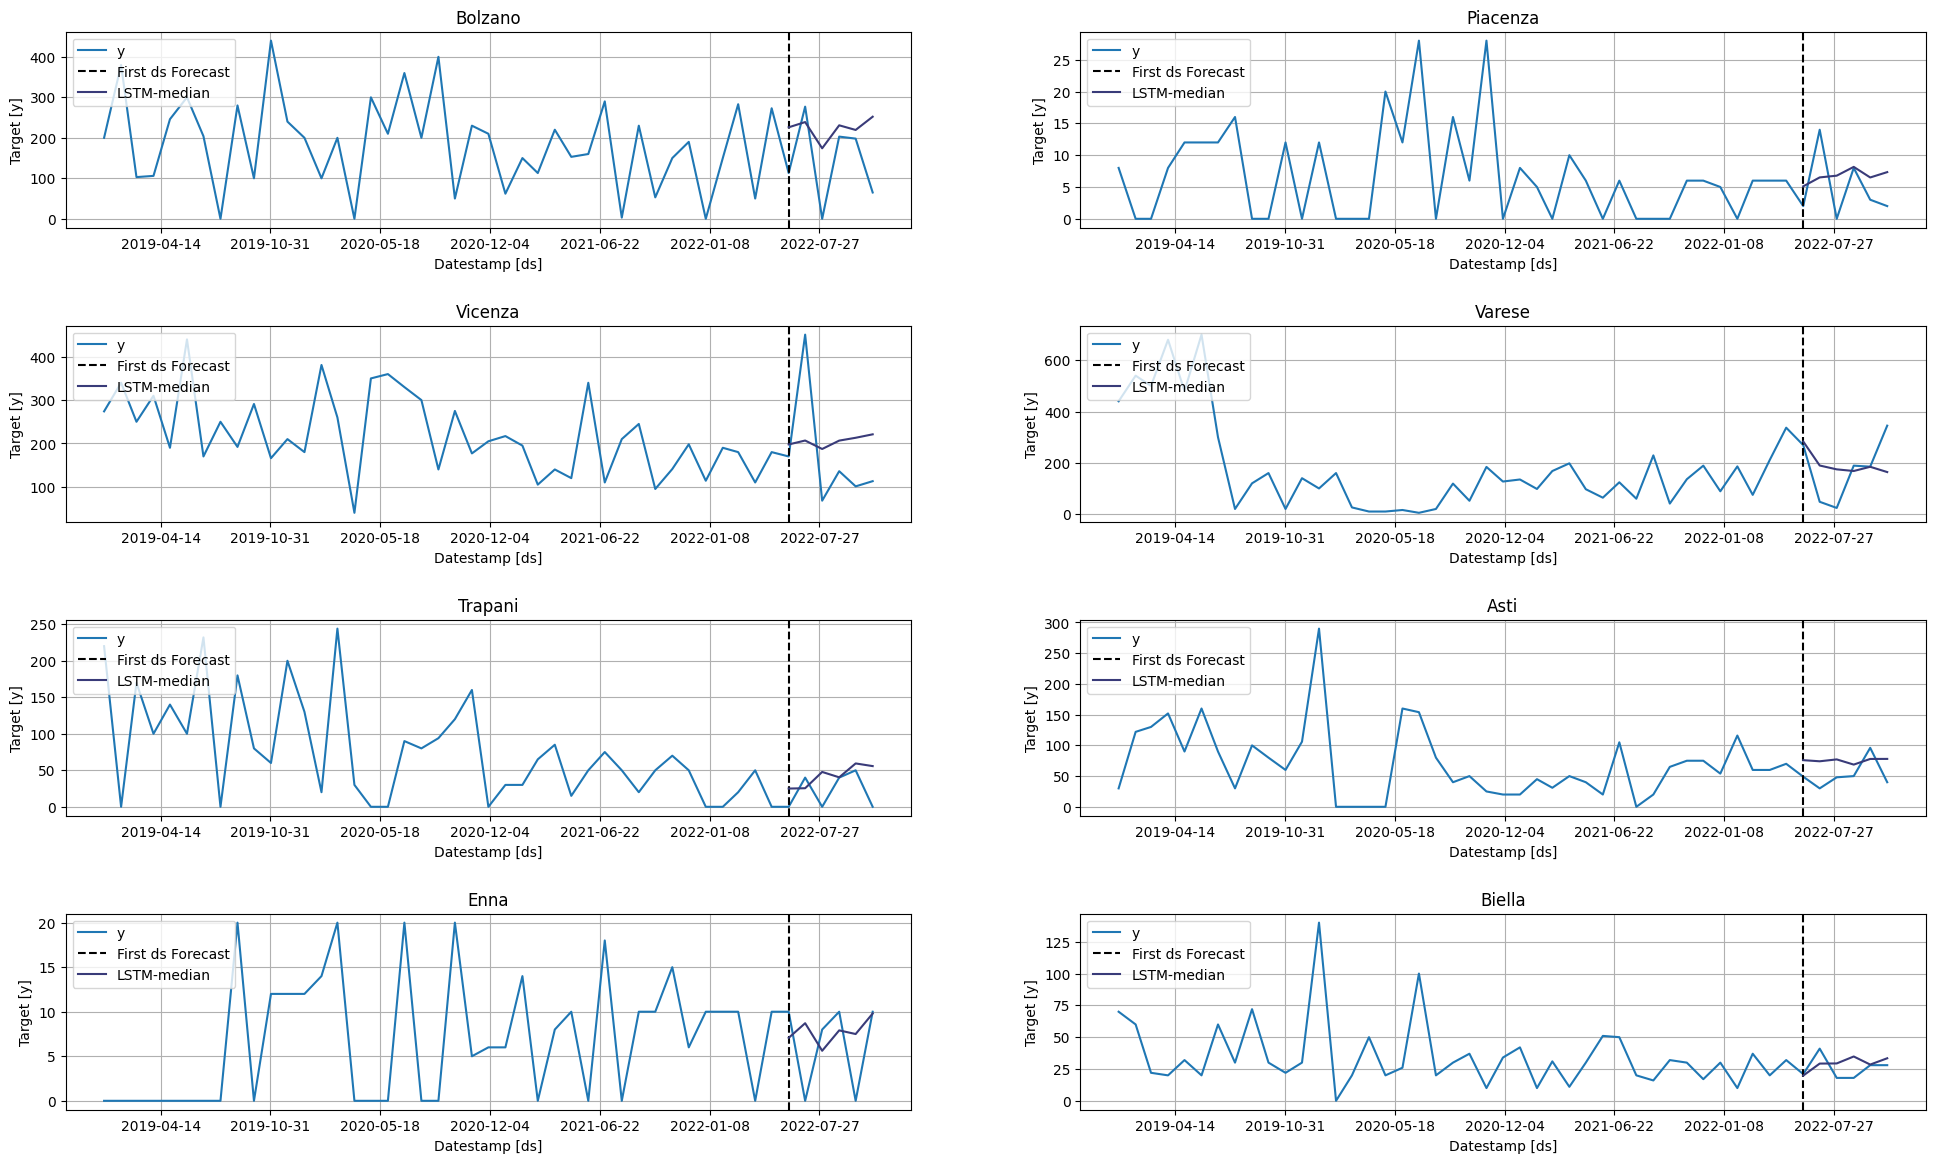

In [153]:
sf.plot(df_nixtla_new, y_hat_new, engine='matplotlib')